# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

v3:
- fix py3dmol incompatibility
- downgrade pytorch since the colab version takes forever to install pytorch_geometric (no binary so it has to compile)
THIS MEANS YOU HAVE TO RUN ALL TWICE!

colab by [@btnaughton](https://twitter.com/btnaughton)

In [ ]:
#@title PDB + SMILES input

PDB_id = '1AO6' #@param {type:"string"}
SMILES_or_pubchem_id = 'C(=O)(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

time: 631 µs (started: 2023-06-18 23:37:30 +00:00)


In [ ]:
# The default version of colab takes forever to install pytorch_geometric
# For now, downgrade (which requires restarting runtime :( )
import os
import torch
if torch.__version__[:6] != "1.13.1":
    !pip uninstall torch torchaudio torchdata torchtext torchvision fastai --y
    !pip install torch==1.13.1
    os.kill(os.getpid(), 9)

time: 523 µs (started: 2023-06-18 23:37:30 +00:00)


In [ ]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

time: 2.7 ms (started: 2023-06-18 23:37:30 +00:00)


In [ ]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

time: 1.73 ms (started: 2023-06-18 23:37:30 +00:00)


In [ ]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

time: 104 ms (started: 2023-06-18 23:37:30 +00:00)


## Install prerequisites

In [ ]:
!pip install ipython-autotime --quiet
%load_ext autotime

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 406 ms (started: 2023-06-18 23:37:30 +00:00)


In [ ]:
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

time: 657 µs (started: 2023-06-18 23:37:31 +00:00)


In [ ]:
try:
    import biopandas
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet

time: 2.11 ms (started: 2023-06-18 23:37:31 +00:00)


In [ ]:
import torch
print(torch.__version__)

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # @ 15573f4674b2a37b1b9adc967df69ef6eee573ea

1.13.1+cu117
time: 529 ms (started: 2023-06-18 23:37:31 +00:00)


## Install ESM and prepare PDB file for ESM

In [ ]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

time: 545 µs (started: 2023-06-18 23:37:31 +00:00)


In [ ]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

/content/DiffDock
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6220.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6246.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6272.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6381.
  warnings.warn(
100% 1/1 [00:00<00:00, 12.98it/s]
time: 809 ms (started: 2023-06-18 23:37:31 +00:00)


In [ ]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Transferred model to GPU
Read data/prepared_for_esm.fasta with 2 sequences
Processing 1 of 1 batches (2 sequences)
time: 18.2 s (started: 2023-06-18 23:37:32 +00:00)


## Run DiffDock

In [ ]:
%cd /content/DiffDock
!python -m inference --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 100 --samples_per_complex 40 --batch_size 6

/content/DiffDock
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00, 32.24it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
loading complexes: 100% 1/1 [00:00<00:00,  1.83it/s]
loading data from memory:  data/cache_torsion/limit0_INDEX_maxLigSizeNone_H0_recRad15.0_recMax24_esmEmbeddings2375672635/heterographs.pkl
Number of complexes:  1
radius protein: mean 61.620758056640625, std 0.0, max 61.620758056640625
radius molecule: mean 5.782405376434326, std 0.0, max 5.782405376434326
distance protein-mol: mean 20.84406852722168, std 0.0, max 20.84406852722168
rmsd matching: mean 0.0, std 0.0, max 0
HAPPENING | confidence model uses different type of graphs than the score model. Loading (or creating if not existing) the data for the confidence model now.
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00, 46.49it/s]
Reading language model embeddings.
Generating graphs for ligands and proteins
l

# Post-process and download results

In [ ]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina

/content/DiffDock
--2023-06-18 23:50:06--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.11.128, 104.18.10.128, 2606:4700::6812:a80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.11.128|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABkj5gv7DZTuDLr2-0P89wd78Ogzzq-dp6aV9m5AOScI2QZelH01SY5G4Q01ZHGWV8DLt1tIp9t_7EpdvIM9ocL2ZiLXw%3D%3D&use_mirror=newcontinuum&r= [following]
--2023-06-18 23:50:07--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABkj5gv7DZTuDLr2-0P89wd78Ogzzq-dp6aV9m5AOScI2QZelH01SY5G4Q01ZHGWV8DLt1tIp9t_7EpdvIM9ocL2ZiLXw%3D%3D&use_mirror=newcontinuum&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/smina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/smina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

#
# create dataframe, tar file and download
#
df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "smina_scored_affinity", "smina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv}

    files.download(f"{tarname}.tar")

/content/DiffDock/results/user_predictions_small


runs:   0%|          | 0/1 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 1min 5s (started: 2023-06-18 23:50:07 +00:00)


## Compare smina affinities with DiffDock confidences

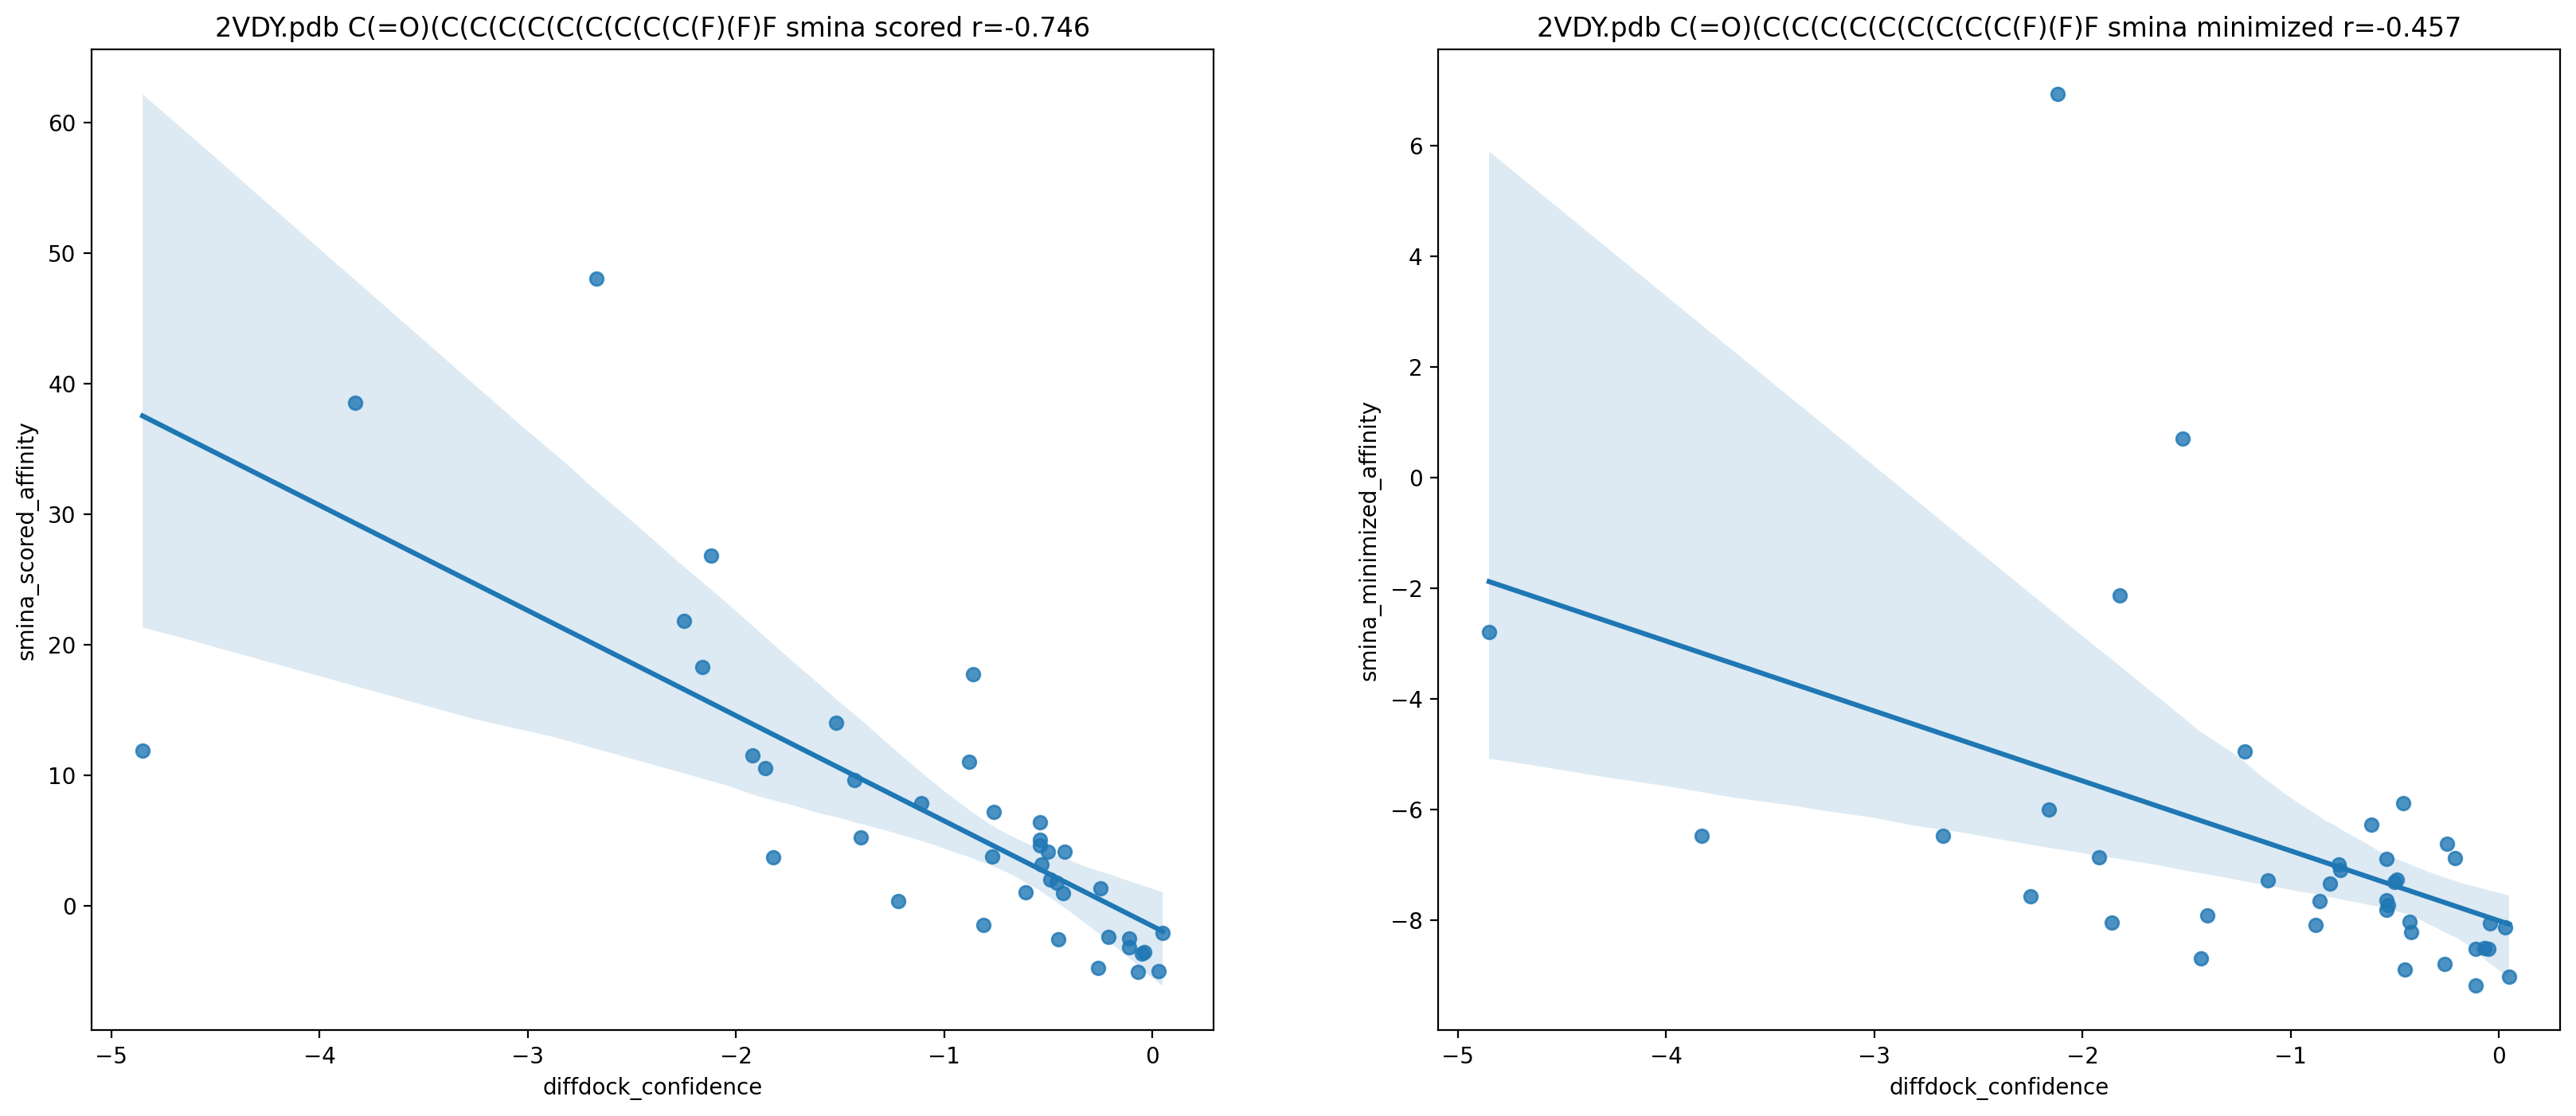

time: 992 ms (started: 2023-06-18 23:51:13 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="smina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="smina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["smina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["smina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} smina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} smina minimized r={r_value_minimized:.3f}");

In [ ]:
df_results.sort_values("diffdock_confidence", ascending=False).head(3)

,pdb_file,smiles,diffdock_confidence,smina_scored_affinity,smina_minimized_affinity,sdf_file
2,2VDY.pdb,C(=O)(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...,0.05,-2.10356,-9.02330,./index0_-tmp-pdb-2VDY.pdb____C(=O)(C(C(C(C(C(...
9,2VDY.pdb,C(=O)(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...,0.03,-4.99775,-8.13666,./index0_-tmp-pdb-2VDY.pdb____C(=O)(C(C(C(C(C(...
33,2VDY.pdb,C(=O)(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...,-0.04,-3.54457,-8.06763,./index0_-tmp-pdb-2VDY.pdb____C(=O)(C(C(C(C(C(...


time: 11.3 ms (started: 2023-06-18 23:51:14 +00:00)


# Visualize top hit (highest confidence) in 3D

In [ ]:
!pip install py3dmol==2.0.3 --quiet

time: 3.62 s (started: 2023-06-18 23:51:14 +00:00)


In [ ]:
from IPython.display import HTML
import py3Dmol

resid_hover = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.chain+" "+atom.resn+" "+atom.resi,
            {position: atom, backgroundColor: 'mintcream', fontColor:'black', fontSize:12});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

view = py3Dmol.view(width=800, height=800)
view.setCameraParameters({'fov': 35, 'z': 100});

# top hit for any pdb file and any smiles
top_hit = df_results.sort_values("diffdock_confidence", ascending=False).iloc[0]
print("top hit:")
display(top_hit)

# add sdf
view.addModel(open(top_hit.sdf_file).read(), "sdf")
view.setStyle({"model": 0}, {'stick':{"color":"#ff0000"}})
view.setViewStyle({"model": 0}, {'style':'outline','color':'black','width':0.1})
view.zoomTo();

# add pdb
view.addModel(open(top_hit.pdb_file).read(), "pdb");
view.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})

model = view.getModel()
model.setHoverable({}, True, resid_hover, unhover_func)

view

top hit:


pdb_file                                                             2VDY.pdb
smiles                      C(=O)(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)...
diffdock_confidence                                                      0.05
smina_scored_affinity                                                -2.10356
smina_minimized_affinity                                              -9.0233
sdf_file                    ./index0_-tmp-pdb-2VDY.pdb____C(=O)(C(C(C(C(C(...
Name: 2, dtype: object

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

time: 26.6 ms (started: 2023-06-18 23:51:18 +00:00)
